$\huge{Recommendation \,\,\, system \,\,\, for \,\,\, book \,\,\, readings}$

First we will import some useful libraries and read the '*.cvs' files to extract the data we need.


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

books =  pd.read_csv('/books.csv')
print(books[5550:6000]['language_code'])

ratings =  pd.read_csv('/ratings.csv')
print('ratings')
print(ratings[:3])

book_tags =  pd.read_csv('/book_tags.csv')
print('book_tags')
print(book_tags[:3])

tags =  pd.read_csv('/tags.csv')
print('tags')
print(tags[:3])

to_read =  pd.read_csv('to_read.csv')
print('to_read')
print(to_read[:3])


5550      eng
5551      eng
5552      eng
5553      eng
5554      eng
        ...  
5995      eng
5996      eng
5997    en-US
5998      eng
5999      eng
Name: language_code, Length: 450, dtype: object
ratings
   user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
book_tags
   goodreads_book_id  tag_id   count
0                  1   30574  167697
1                  1   11305   37174
2                  1   11557   34173
tags
   tag_id tag_name
0       0        -
1       1     --1-
2       2    --10-
to_read
   user_id  book_id
0        9        8
1       15      398
2       15      275


$\huge{Part \,\,\, 1 : Analyze \,\,\, the \,\,\, data}$

First we will suppress ratings that link the same user to the same book more than once.

In [ ]:
# Group by 'user_id' and 'book_id' and count occurrences
ratings['duplicate'] = ratings.groupby(['user_id', 'book_id'])['user_id'].transform('count')

# Print the number of duplicate ratings
num_duplicates = len(ratings[ratings['duplicate'] > 1])
print(f'Number of duplicate ratings: {num_duplicates}')

# Keep only the rows where N == 1
ratings = ratings[ratings['duplicate'] == 1]

# Optionally, you can drop the 'N' column if it's no longer needed
ratings = ratings.drop(columns=['duplicate'])

# Display the first 4 rows of the cleaned DataFrame
print(ratings.head(4))

Number of duplicate ratings: 0
   user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5


<ipython-input-23-5759bdd68330>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='YlGnBu', edgecolor='grey')


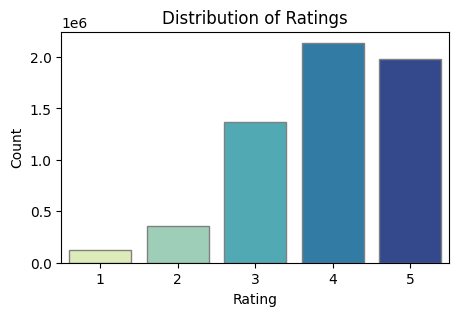

In [ ]:
# Plot the distribution of ratings
plt.figure(figsize=(5, 3))
sns.countplot(x='rating', data=ratings, palette='YlGnBu', edgecolor='grey')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

200


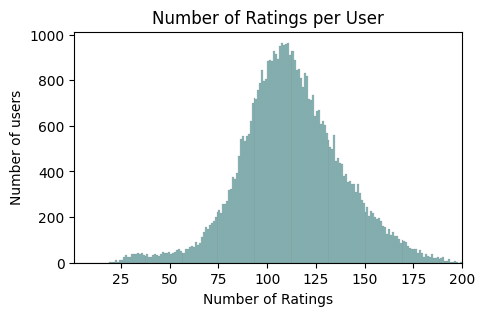

In [ ]:
# Group by 'user_id' and calculate the number of ratings per user
ratings_per_user = ratings.groupby('user_id').size().reset_index(name='number_of_ratings_per_user')
print(max(ratings_per_user['number_of_ratings_per_user']))

# Plot the distribution of the number of ratings per user
plt.figure(figsize=(5, 3))
sns.histplot(ratings_per_user['number_of_ratings_per_user'], bins=range(0, 201), kde=False, color='cadetblue', edgecolor='grey')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of users')
plt.xlim(1, 200)
plt.show()

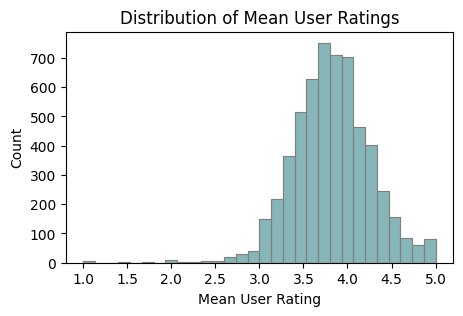

In [ ]:
# Group by 'user_id' and calculate the mean rating per user
mean_ratings_per_user = ratings.groupby('user_id')['rating'].mean().reset_index(name='mean_user_rating')

# Plot the distribution of mean user ratings
plt.figure(figsize=(5, 3))
sns.histplot(mean_ratings_per_user['mean_user_rating'], bins=30, kde=False, color='cadetblue', edgecolor='grey')
plt.title('Distribution of Mean User Ratings')
plt.xlabel('Mean User Rating')
plt.ylabel('Count')
plt.show()

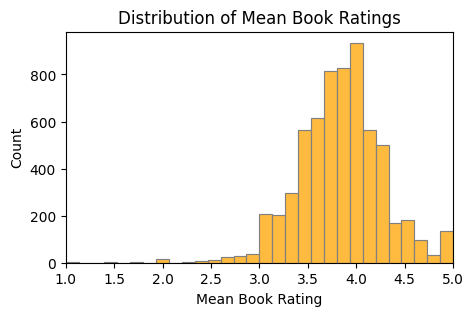

17779


<ipython-input-8-dd8637fa9408>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='percentage', y='tag_name', data=tmp.sort_values(by='percentage', ascending=False), palette='YlOrRd')


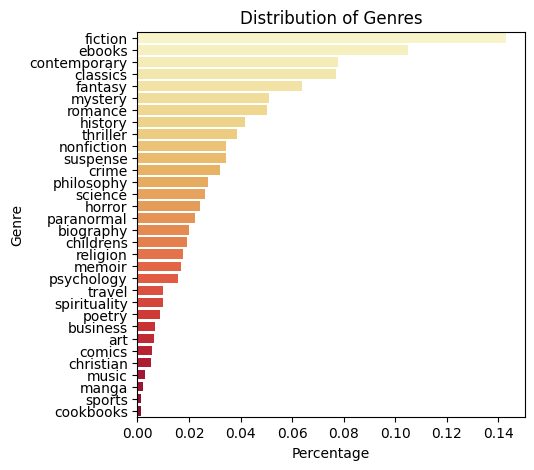

In [ ]:
# Distribution of mean book ratings
mean_ratings_per_book = ratings.groupby('book_id')['rating'].mean().reset_index(name='mean_book_rating')

plt.figure(figsize=(5, 3))
sns.histplot(mean_ratings_per_book['mean_book_rating'], bins=30, kde=False, color='orange', edgecolor='grey')
plt.title('Distribution of Mean Book Ratings')
plt.xlabel('Mean Book Rating')
plt.ylabel('Count')
plt.xlim(1, 5)  # Limit x-axis to match R code
plt.show()

# Extracting and plotting the distribution of genres
genres = ["Art", "Biography", "Business", "Chick Lit", "Childrens", "Christian", "Classics", "Comics", "Contemporary", "Cookbooks", "Crime", "Ebooks", "Fantasy", "Fiction", "Gay and Lesbian", "Graphic Novels", "Historical Fiction", "History", "Horror", "Humor and Comedy", "Manga", "Memoir", "Music", "Mystery", "Nonfiction", "Paranormal", "Philosophy", "Poetry", "Psychology", "Religion", "Romance", "Science", "Science Fiction", "Self Help", "Suspense", "Spirituality", "Sports", "Thriller", "Travel", "Young Adult"]

available_genres = [genre.lower() for genre in genres if genre.lower() in tags['tag_name'].str.lower().values]


available_tags = tags.loc[tags['tag_name'].str.lower().isin(available_genres), 'tag_id']

tmp = book_tags.loc[book_tags['tag_id'].isin(available_tags)].groupby('tag_id').size().reset_index(name='n').merge(tags, on='tag_id', how='left')
tmp['sumN'] = tmp['n'].sum()
tmp['percentage'] = tmp['n'] / tmp['sumN']

print(tmp['sumN'][1])


plt.figure(figsize=(5, 5))
sns.barplot(x='percentage', y='tag_name', data=tmp.sort_values(by='percentage', ascending=False), palette='YlOrRd')
plt.xlabel('Percentage')
plt.ylabel('Genre')
plt.title('Distribution of Genres')
plt.show()

In [ ]:

available_tags = tags.loc[tags['tag_name'].str.lower().isin(available_genres), 'tag_id']

tmp = book_tags.loc[book_tags['tag_id'].isin(available_tags)].groupby('tag_id').size().reset_index(name='n').merge(tags, on='tag_id', how='left')
print(tags['tag_name'][26:50].str.lower().values)
print(tags['tag_name'].str.lower().unique()[500:600])

['-fictional' '-fictitious' '-football-' '-george' '-gr-' '-history'
 '-imaginary' '-italy-' '-la--' '-los' '-mass--' '-murder-' '-n-y--'
 '-non-poetry-' '-performing' '-post' '-psychology-' '-read' '-single'
 '-specific' '-television' '0' '0-0-0-0cant-find' '0-0-bingo']
['1998' '1998-modern-library-100-best' '1998-read-books' '1999'
 '1999-and-before' '1999-books' '19th' '19th-c' '19th-c-philosophy'
 '19th-century' '19th-century-american' '19th-century-americans-in-paris'
 '19th-century-british' '19th-century-british-literature'
 '19th-century-china' '19th-century-classics' '19th-century-england'
 '19th-century-fairy-tales' '19th-century-fiction'
 '19th-century-french-literature' '19th-century-history'
 '19th-century-lit' '19th-century-literature' '1a-toppicks-own'
 '1ab-bookcount-5' '1ax-sorting-7-case-7b' '1b-wantdigital' '1e-toppicks'
 '1k-books-before-kindergarten' '1kbbk' '1kindle-available' '1non-fiction'
 '1overdrive' '1postwar379404nf-other' '1q84' '1rhave' '1st' '1st-batch'
 

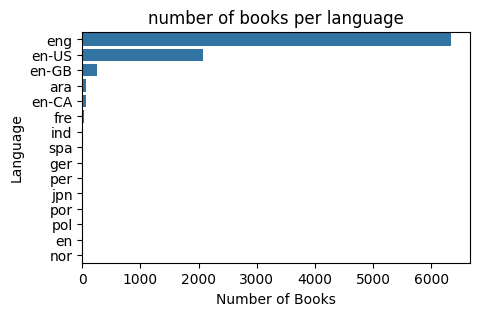

In [ ]:
# Plot the distributions
plt.figure(figsize=(5, 3))

# plot the languages
sns.countplot(y='language_code', data=books, order=books['language_code'].value_counts().index[:15])
plt.xlabel('Number of Books')
plt.ylabel('Language')
plt.title('number of books per language')
plt.show()

The users that rated more books seems to have a lower mean rating

<Figure size 700x400 with 0 Axes>

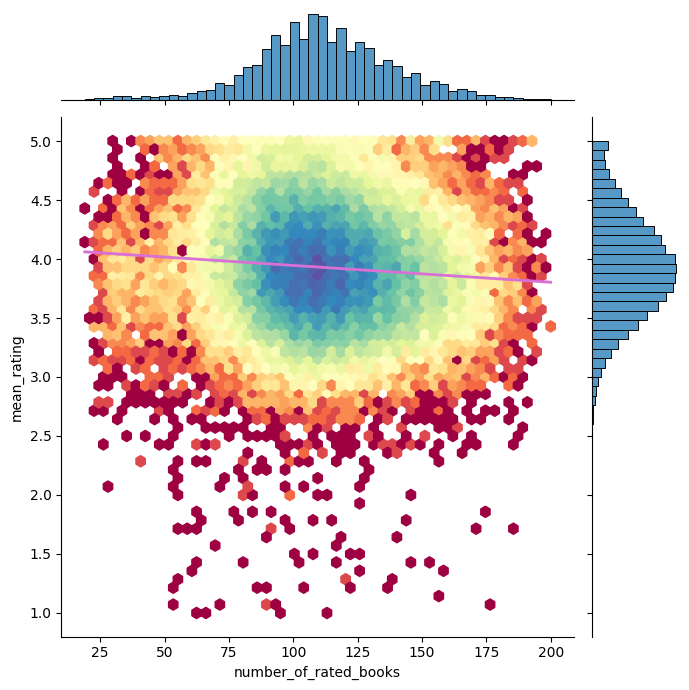

In [ ]:
# Group and summarize: Calculate the mean rating and number of rated books for each user
tmp = ratings.groupby('user_id').agg(mean_rating=('rating', 'mean'), number_of_rated_books=('rating', 'count')).reset_index()

# Filter: Exclude users who have rated more than 100 books
tmp_filtered = tmp

# Hexbin plot with trend line
plt.figure(figsize=(7, 4))
sns.jointplot(x='number_of_rated_books', y='mean_rating', data=tmp_filtered, kind='hex', bins='log', cmap='Spectral', marginal_kws=dict(bins=50), height=7)
sns.regplot(x='number_of_rated_books', y='mean_rating', data=tmp_filtered, scatter=False, color='orchid', line_kws={'linewidth': 2})
plt.show()

In [ ]:
# Get unique user_ids and book_ids
user_ids = sorted(ratings['user_id'].unique())
book_ids = sorted(ratings['book_id'].unique())

# Create a pivot table with user_ids as index, book_ids as columns, and ratings as values
rating_matrix = ratings.pivot(index='user_id', columns='book_id', values='rating')

# Reorder the columns to match the sorted book_ids
rating_matrix = rating_matrix[book_ids]

# Convert to a NumPy array
rating_matrix_array = rating_matrix.to_numpy()

# Print the dimensions of the rating matrix
print("Dimensions:", rating_matrix.shape)

Dimensions: (53424, 10000)
